<a href="https://colab.research.google.com/github/MuhammedAshraf2020/BreastCancerHist/blob/main/Breast/BreastCanceripynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/Drive")

Mounted at /content/Drive


In [ ]:
d = "4/1AY0e-g6fGA3P990S_pVX7gwjppCXcwJ7OaEZtuWtsxr9FJOaO7z2K22l_qM"

# Import libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rescale , resize
import cv2
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras
from keras.preprocessing.image  import ImageDataGenerator
from keras.layers    import Flatten,Dense,Dropout,BatchNormalization
from keras.models    import Model , Sequential
from keras.utils     import to_categorical
from keras.layers    import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import  EarlyStopping , ModelCheckpoint
from keras.regularizers import l2
import shutil
from utils import Data

# Create Data Folders

In [40]:
path = "/content/Drive/MyDrive/BreaKHis_v1/histology_slides/breast"

In [75]:
data = Data(path)

In [76]:
data.generate()

100%|██████████| 38/38 [00:00<00:00, 1037.14it/s]


In [ ]:
code = {0:"Adenosis" , 1 : "Fibroadenoma" , 2 :"Phyllodes Tumor" , 3 : "Tubular Adenoma",  4 : "Ductal Carcinoma",  5 : "Lobular Carcinoma" , 6 : "Mucinous Carcinoma" , 7:"Papillary Carcinoma" }

# Show Sample of images (8 classes)

In [90]:
main_path = "/content/data"
sample = []
edges  = []

for cls in os.listdir("/content/train"):
  path = "/content/train" + "/"  + cls
  for img in os.listdir(path):
    img_path = os.path.join(path , img)
    sample.append(cv2.imread(img_path))
    edges.append(cv2.Canny(cv2.imread(img_path , 0) , 100 , 200))
    break

In [91]:
sample = np.array(sample)

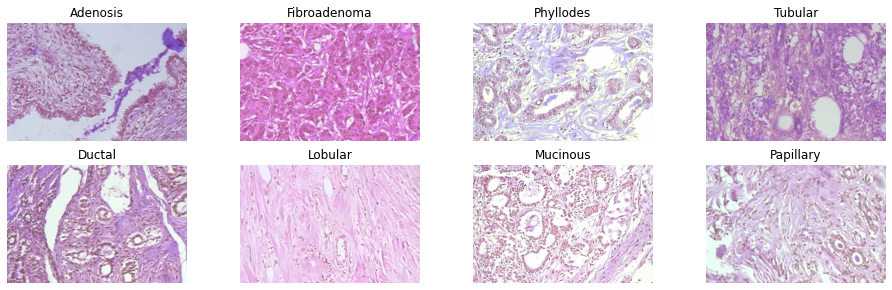

In [93]:
plt.figure(figsize = (16 , 10))
for n , i in enumerate(range(8)):
    plt.subplot(4 , 4 , n +1)
    plt.imshow(sample[i])
    plt.axis("off")
    plt.title(code[i])

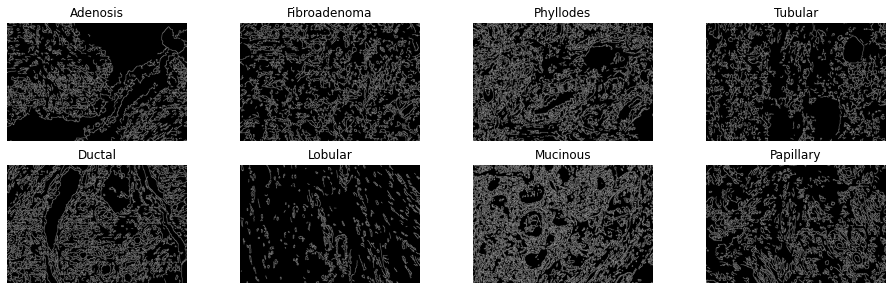

In [94]:
plt.figure(figsize = (16 , 10))
for n , i in enumerate(range(8)):
    plt.subplot(4 , 4 , n +1)
    plt.imshow(edges[i] , "gray")
    plt.axis("off")
    plt.title(code[i])

# Data Generator

In [98]:
train_datagen = ImageDataGenerator(
        rotation_range=90,
        rescale=1./255,  
        zoom_range = 0.2,
        horizontal_flip=True,  
        vertical_flip = True)

train_generator = train_datagen.flow_from_directory(
    "/content/train" ,
    target_size = (224 , 224) ,
    batch_size  = 32 
)

val_datagen = ImageDataGenerator(
        rotation_range =90,
        rescale=1./255,
        zoom_range = 0.2, 
        horizontal_flip = True,  
        vertical_flip = True)

val_generator = val_datagen.flow_from_directory(
    "/content/val" ,
    target_size = (224 , 224) ,
    batch_size = 32
)

Found 1492 images belonging to 8 classes.
Found 377 images belonging to 8 classes.


# Build Model

In [99]:
base_model = keras.applications.DenseNet201(weights="imagenet", include_top = False,
	input_tensor = keras.layers.Input(shape=(224, 224, 3)))

74842112/74836368 [==============================] - 1s 0us/step


In [100]:
for layer in base_model.layers:
  layer.trainable = True

In [101]:
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024 ,activation='relu', kernel_regularizer=l2(l=0.03)))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(8,activation='softmax'))

In [ ]:
model.summary()

# Set Callbacks

In [102]:
callback = [ModelCheckpoint("/content/checkpoint2" ,
                                            monitor='val_accuracy', mode='max', 
                                            save_best_only=True) ,
            EarlyStopping(monitor='val_accuracy' , patience = 12)]

# Model fitting

In [103]:
model.compile( optimizer=keras.optimizers.Adam(lr = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [108]:
hist = model.fit_generator(train_generator , validation_data = val_generator , epochs = 50  , callbacks = callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
47/47 [==============================] - 52s 1s/step - loss: 25.9116 - accuracy: 0.6635 - val_loss: 24.4111 - val_accuracy: 0.4615
INFO:tensorflow:Assets written to: /content/checkpoint2/assets
Epoch 2/50
47/47 [==============================] - 51s 1s/step - loss: 21.8130 - accuracy: 0.7708 - val_loss: 20.8666 - val_accuracy: 0.4854
INFO:tensorflow:Assets written to: /content/checkpoint2/assets
Epoch 3/50
47/47 [==============================] - 51s 1s/step - loss: 18.6551 - accuracy: 0.8070 - val_loss: 18.3653 - val_accuracy: 0.4987
INFO:tensorflow:Assets written to: /content/checkpoint2/assets
Epoch 4/50
47/47 [==============================] - 51s 1s/step - loss: 16.1723 - accuracy: 0.8398 - val_loss: 15.8690 - val_accuracy: 0.5756
INFO:tensorflow:Assets written to: /content/checkpoint2/assets
Epoch 5/50
47/47 [==============================] - 51s 1s/step - loss: 14.1886 - accuracy: 0.8592 - val_loss: 13.6972 - val_accuracy: 0.7454
INFO:tensorflow:Assets written to: /co

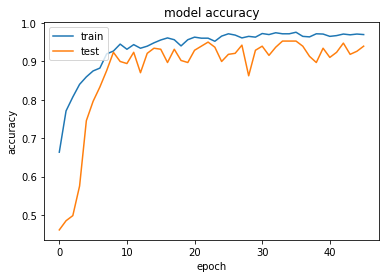

In [109]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

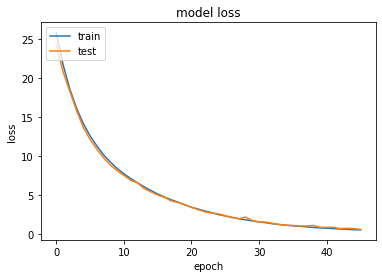

In [110]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/test"
)

Found 212 images belonging to 8 classes.


In [115]:
model.evaluate(test_generator) 

7/7 [==============================] - 9s 867ms/step - loss: 0.7300 - accuracy: 0.8679


[0.730032205581665, 0.8679245114326477]

In [116]:
model_checked = keras.models.load_model("/content/checkpoint2")

In [117]:
model_checked.evaluate(test_generator)

7/7 [==============================] - 6s 444ms/step - loss: 1.3751 - accuracy: 0.9198


[1.3750615119934082, 0.9198113083839417]